In [1]:
import os
import shutil

for root, dirs, files in os.walk(".", topdown=False):
    for name in dirs:
        if name == ".ipynb_checkpoints":
            dir_path = os.path.join(root, name)
            shutil.rmtree(dir_path)
            print(f"Removed {dir_path}")


In [2]:
import torch
from torch.utils.data import DataLoader
from PIL import Image
import json
import re
from typing import Optional
from os import listdir
from os.path import isfile, join
from tqdm.auto import tqdm
from PIL import Image
from tqdm.notebook import tqdm
from transformers import ViltConfig
from transformers import ViltProcessor
from transformers import ViltForQuestionAnswering
import numpy as np
from dataloader import *
from train import *
torch.manual_seed(41)

In [3]:
config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
tr_image_root = 'V1/train2014/train2014'
tr_q_root = open('V1/Questions_Train_mscoco/OpenEnded_mscoco_train2014_questions.json')
tr_a_root = open('V1/Annotations_Train_mscoco/mscoco_train2014_annotations.json')

val_image_root = 'V1/val2014/val2014'
val_q_root = open('V1/Questions_Val_mscoco/OpenEnded_mscoco_val2014_questions.json')
val_a_root = open('V1/Annotations_Val_mscoco/mscoco_val2014_annotations.json')

'''ts_image_root = '/home/mpervin/LLM/Datasets/v2/val2014'
ts_q_root = open('/home/mpervin/LLM/Datasets/v2/v2_OpenEnded_mscoco_val2014_questions.json')
ts_a_root = open('/home/mpervin/LLM/Datasets/v2/v2_mscoco_val2014_annotations.json')'''

print("--------Training Data-------")
tr_questions, tr_annotations, tr_id_to_filename = load_data(tr_image_root,tr_q_root,tr_a_root, config)
print("--------Validation Data-------")
val_questions, val_annotations, val_id_to_filename = load_data(val_image_root,val_q_root,val_a_root, config)
#print("--------Testing Data-------")
#ts_questions, ts_annotations, ts_id_to_filename = load_data(ts_image_root,ts_q_root,ts_a_root, config)

--------Training Data-------


  0%|          | 0/82783 [00:00<?, ?it/s]

data questions keys: dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 248349
data annotations keys: dict_keys(['info', 'data_type', 'license', 'data_subtype', 'annotations'])
Number of annotations: 248349


  0%|          | 0/248349 [00:00<?, ?it/s]

--------Validation Data-------


  0%|          | 0/40504 [00:00<?, ?it/s]

data questions keys: dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 121512
data annotations keys: dict_keys(['info', 'data_type', 'license', 'data_subtype', 'annotations'])
Number of annotations: 121512


  0%|          | 0/121512 [00:00<?, ?it/s]

In [4]:
len(val_id_to_filename)
val_questions[0]

{'question': 'What is the table made of?',
 'image_id': 350623,
 'question_id': 3506232}

{'question': 'What shape is the bench seat?', 'image_id': 487025, 'question_id': 4870250}
[682, 970, 50, 2628]
['oval', 'curved', 'banana', 'wavy']
[0.3333333333333333, 1.0, 0.3333333333333333, 0.3333333333333333]


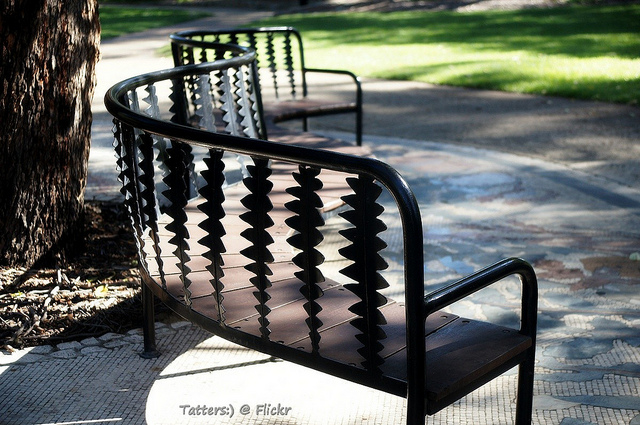

In [5]:
tr_path = tr_id_to_filename[tr_questions[0]['image_id']]
tr_image = Image.open(tr_path)
tr_labels = tr_annotations[0]['labels']
tr_scores = tr_annotations[0]['scores']
print(tr_questions[0])
print(tr_labels)
print([config.id2label[label] for label in tr_labels])
print(tr_scores)
tr_image

{'question': 'What is the table made of?', 'image_id': 350623, 'question_id': 3506232}
[83]
['wood']
[1.0]


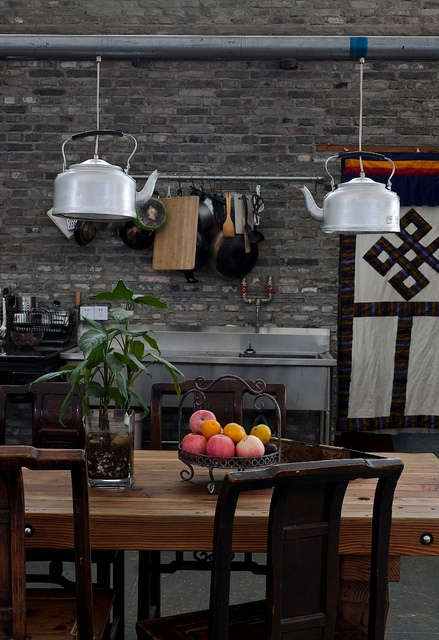

In [6]:
val_path = val_id_to_filename[val_questions[0]['image_id']]
val_image = Image.open(val_path)
val_labels = val_annotations[0]['labels']
val_scores = val_annotations[0]['scores']
print(val_questions[0])
print(val_labels)
print([config.id2label[label] for label in val_labels])
print(val_scores)
val_image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

tr_size = int(len(tr_questions)*0.001)
val_size = int(len(val_questions)*0.001)

ts_size = int(len(val_questions)*0.01)

tr_dataset = VQADataset(questions = tr_questions[:tr_size], 
                        annotations = tr_annotations[:tr_size], 
                        id_to_filename = tr_id_to_filename, 
                        processor = processor, 
                        config = config)
val_dataset = VQADataset(questions = val_questions[:val_size], 
                         annotations = val_annotations[:val_size], 
                         id_to_filename = val_id_to_filename, 
                         processor = processor,
                         config = config)
ts_dataset = VQADataset(questions = val_questions[val_size:1000], 
                         annotations = val_annotations[val_size:1000], 
                         id_to_filename = val_id_to_filename, 
                         processor = processor,
                         config = config)


model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",id2label=config.id2label,label2id=config.label2id)
model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [5]:
from torch.utils.data import DataLoader

print("--------Training Data-------")
train_dataloader = DataLoader(tr_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
print(len(train_dataloader))
tr_batch = next(iter(train_dataloader))
for k, v in tr_batch.items():
    print(k, v.shape)

print("--------Validation Data-------")
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
print(len(val_dataloader))
val_batch = next(iter(val_dataloader))
for k, v in val_batch.items():
    print(k, v.shape)

print("--------Testing Data-------")
# Create a test DataLoader similar to train and validation loaders
test_dataloader = DataLoader(ts_dataset, collate_fn=collate_fn, batch_size=4, shuffle=False)  # shuffle=False for test
print(len(test_dataloader))
ts_batch = next(iter(test_dataloader))
for k, v in ts_batch.items():
    print(k, v.shape)


--------Training Data-------
62
input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 384, 576])
pixel_mask torch.Size([4, 384, 576])
labels torch.Size([4, 3129])
--------Validation Data-------
31
input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 384, 512])
pixel_mask torch.Size([4, 384, 512])
labels torch.Size([4, 3129])
--------Testing Data-------
220
input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 576, 576])
pixel_mask torch.Size([4, 576, 576])
labels torch.Size([4, 3129])


In [6]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Optimizer setup
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 100
save_path = 'LLM/models/teacher_models/'
teacher_train_results = train_and_validate(model,train_dataloader, val_dataloader, optimizer, epochs,save_path, device)

Epoch: 1/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 1008.3188, Top-5 Accuracy: 0.0163, Overall Accuracy: 0.0000


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]


Validation - Loss: 324.4396, Top-5 Accuracy: 0.2286, Overall Accuracy: 0.0048
Teacher model saved to LLM/models/teacher_models/
Epoch: 2/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Training - Loss: 188.0318, Top-5 Accuracy: 0.2525, Overall Accuracy: 0.1752


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Validation - Loss: 110.0838, Top-5 Accuracy: 0.3952, Overall Accuracy: 0.2286
Epoch: 3/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 81.7936, Top-5 Accuracy: 0.2953, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Validation - Loss: 60.1142, Top-5 Accuracy: 0.4048, Overall Accuracy: 0.2286
Epoch: 4/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Training - Loss: 49.5838, Top-5 Accuracy: 0.3218, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.99it/s]


Validation - Loss: 39.9435, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 5/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 34.9371, Top-5 Accuracy: 0.3483, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.99it/s]


Validation - Loss: 29.4949, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 6/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


Training - Loss: 26.9174, Top-5 Accuracy: 0.3523, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


Validation - Loss: 23.4058, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 7/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Training - Loss: 21.9917, Top-5 Accuracy: 0.3503, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]


Validation - Loss: 19.4335, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 8/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.59it/s]


Training - Loss: 18.7260, Top-5 Accuracy: 0.3564, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]


Validation - Loss: 16.7284, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 9/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Training - Loss: 16.4488, Top-5 Accuracy: 0.3544, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]


Validation - Loss: 14.7975, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 10/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Training - Loss: 14.7808, Top-5 Accuracy: 0.3523, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]


Validation - Loss: 13.4790, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 11/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Training - Loss: 13.5310, Top-5 Accuracy: 0.3544, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


Validation - Loss: 12.4204, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Teacher model saved to LLM/models/teacher_models/
Epoch: 12/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Training - Loss: 12.5563, Top-5 Accuracy: 0.3564, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:17<00:00,  1.82it/s]


Validation - Loss: 11.7238, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 13/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Training - Loss: 11.7914, Top-5 Accuracy: 0.3564, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


Validation - Loss: 11.0182, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 14/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 11.1627, Top-5 Accuracy: 0.3564, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]


Validation - Loss: 10.4475, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 15/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


Training - Loss: 10.6605, Top-5 Accuracy: 0.3564, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s]


Validation - Loss: 10.0221, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 16/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.59it/s]


Training - Loss: 10.2254, Top-5 Accuracy: 0.3523, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:21<00:00,  1.43it/s]


Validation - Loss: 9.7746, Top-5 Accuracy: 0.4524, Overall Accuracy: 0.2286
Epoch: 17/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 9.8689, Top-5 Accuracy: 0.3523, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 9.2300, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 18/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 9.5619, Top-5 Accuracy: 0.3564, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 9.0938, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 19/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 9.2828, Top-5 Accuracy: 0.3503, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


Validation - Loss: 8.7321, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 20/100


Training: 100%|██████████| 62/62 [00:40<00:00,  1.51it/s]


Training - Loss: 9.0200, Top-5 Accuracy: 0.3483, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.94it/s]


Validation - Loss: 8.5395, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 21/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 8.7362, Top-5 Accuracy: 0.3544, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]


Validation - Loss: 8.4551, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Teacher model saved to LLM/models/teacher_models/
Epoch: 22/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Training - Loss: 8.4625, Top-5 Accuracy: 0.3564, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 8.0571, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 23/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 8.2246, Top-5 Accuracy: 0.3564, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]


Validation - Loss: 7.8452, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 24/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 8.0273, Top-5 Accuracy: 0.3564, Overall Accuracy: 0.1813


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Validation - Loss: 8.0595, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 25/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Training - Loss: 7.8477, Top-5 Accuracy: 0.3585, Overall Accuracy: 0.1853


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]


Validation - Loss: 7.7997, Top-5 Accuracy: 0.4286, Overall Accuracy: 0.2286
Epoch: 26/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Training - Loss: 7.6949, Top-5 Accuracy: 0.3646, Overall Accuracy: 0.1976


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]


Validation - Loss: 7.5345, Top-5 Accuracy: 0.4524, Overall Accuracy: 0.2381
Epoch: 27/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


Training - Loss: 7.5317, Top-5 Accuracy: 0.3686, Overall Accuracy: 0.2098


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]


Validation - Loss: 7.6267, Top-5 Accuracy: 0.4571, Overall Accuracy: 0.2381
Epoch: 28/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


Training - Loss: 7.3685, Top-5 Accuracy: 0.3829, Overall Accuracy: 0.2159


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 7.2959, Top-5 Accuracy: 0.4571, Overall Accuracy: 0.2429
Epoch: 29/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 7.2230, Top-5 Accuracy: 0.3849, Overall Accuracy: 0.2138


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.94it/s]


Validation - Loss: 7.1934, Top-5 Accuracy: 0.4714, Overall Accuracy: 0.2381
Epoch: 30/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 7.0702, Top-5 Accuracy: 0.3931, Overall Accuracy: 0.2159


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


Validation - Loss: 7.1977, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2381
Epoch: 31/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


Training - Loss: 6.9346, Top-5 Accuracy: 0.4012, Overall Accuracy: 0.2179


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]


Validation - Loss: 7.0694, Top-5 Accuracy: 0.4810, Overall Accuracy: 0.2429
Teacher model saved to LLM/models/teacher_models/
Epoch: 32/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Training - Loss: 6.7933, Top-5 Accuracy: 0.4053, Overall Accuracy: 0.2179


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


Validation - Loss: 7.2848, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2333
Epoch: 33/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 6.6859, Top-5 Accuracy: 0.4155, Overall Accuracy: 0.2261


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]


Validation - Loss: 6.9445, Top-5 Accuracy: 0.4857, Overall Accuracy: 0.2286
Epoch: 34/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Training - Loss: 8.0337, Top-5 Accuracy: 0.4175, Overall Accuracy: 0.2220


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 7.3515, Top-5 Accuracy: 0.4524, Overall Accuracy: 0.2286
Epoch: 35/100


Training: 100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


Training - Loss: 7.0078, Top-5 Accuracy: 0.3829, Overall Accuracy: 0.1914


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


Validation - Loss: 7.0205, Top-5 Accuracy: 0.4667, Overall Accuracy: 0.2190
Epoch: 36/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


Training - Loss: 6.7012, Top-5 Accuracy: 0.4012, Overall Accuracy: 0.2098


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Validation - Loss: 6.9383, Top-5 Accuracy: 0.4762, Overall Accuracy: 0.2286
Epoch: 37/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 6.5145, Top-5 Accuracy: 0.4134, Overall Accuracy: 0.2220


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


Validation - Loss: 6.8242, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2333
Epoch: 38/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Training - Loss: 6.3928, Top-5 Accuracy: 0.4155, Overall Accuracy: 0.2200


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.94it/s]


Validation - Loss: 6.8124, Top-5 Accuracy: 0.4810, Overall Accuracy: 0.2381
Epoch: 39/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Training - Loss: 6.2799, Top-5 Accuracy: 0.4155, Overall Accuracy: 0.2322


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]


Validation - Loss: 6.8109, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2286
Epoch: 40/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Training - Loss: 6.1543, Top-5 Accuracy: 0.4216, Overall Accuracy: 0.2301


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.94it/s]


Validation - Loss: 6.7922, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2381
Epoch: 41/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Training - Loss: 6.0997, Top-5 Accuracy: 0.4358, Overall Accuracy: 0.2424


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.85it/s]


Validation - Loss: 7.0001, Top-5 Accuracy: 0.4857, Overall Accuracy: 0.2381
Teacher model saved to LLM/models/teacher_models/
Epoch: 42/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 6.0384, Top-5 Accuracy: 0.4297, Overall Accuracy: 0.2505


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


Validation - Loss: 6.7165, Top-5 Accuracy: 0.4857, Overall Accuracy: 0.2286
Epoch: 43/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


Training - Loss: 5.8333, Top-5 Accuracy: 0.4379, Overall Accuracy: 0.2505


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]


Validation - Loss: 6.8687, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2381
Epoch: 44/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Training - Loss: 5.6570, Top-5 Accuracy: 0.4542, Overall Accuracy: 0.2688


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.83it/s]


Validation - Loss: 6.6939, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2333
Epoch: 45/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 5.5142, Top-5 Accuracy: 0.4521, Overall Accuracy: 0.2749


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Validation - Loss: 6.6014, Top-5 Accuracy: 0.4762, Overall Accuracy: 0.1952
Epoch: 46/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 5.4125, Top-5 Accuracy: 0.4644, Overall Accuracy: 0.2912


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Validation - Loss: 6.7602, Top-5 Accuracy: 0.4762, Overall Accuracy: 0.2238
Epoch: 47/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Training - Loss: 5.2300, Top-5 Accuracy: 0.4888, Overall Accuracy: 0.2933


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


Validation - Loss: 6.6217, Top-5 Accuracy: 0.4714, Overall Accuracy: 0.2048
Epoch: 48/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 5.1120, Top-5 Accuracy: 0.5153, Overall Accuracy: 0.3014


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]


Validation - Loss: 6.5794, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2048
Epoch: 49/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Training - Loss: 5.0309, Top-5 Accuracy: 0.5295, Overall Accuracy: 0.3075


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


Validation - Loss: 6.5703, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2286
Epoch: 50/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.63it/s]


Training - Loss: 4.8537, Top-5 Accuracy: 0.5601, Overall Accuracy: 0.3238


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]


Validation - Loss: 6.6126, Top-5 Accuracy: 0.4762, Overall Accuracy: 0.2190
Epoch: 51/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 4.6858, Top-5 Accuracy: 0.5967, Overall Accuracy: 0.3381


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


Validation - Loss: 6.8989, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2190
Teacher model saved to LLM/models/teacher_models/
Epoch: 52/100


Training: 100%|██████████| 62/62 [00:39<00:00,  1.58it/s]


Training - Loss: 4.5753, Top-5 Accuracy: 0.6090, Overall Accuracy: 0.3544


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]


Validation - Loss: 6.5041, Top-5 Accuracy: 0.4857, Overall Accuracy: 0.2190
Epoch: 53/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]


Training - Loss: 4.3908, Top-5 Accuracy: 0.6415, Overall Accuracy: 0.3686


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]


Validation - Loss: 6.5948, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2143
Epoch: 54/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 4.2412, Top-5 Accuracy: 0.6578, Overall Accuracy: 0.3931


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 6.5904, Top-5 Accuracy: 0.4857, Overall Accuracy: 0.2095
Epoch: 55/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


Training - Loss: 4.0886, Top-5 Accuracy: 0.6782, Overall Accuracy: 0.3992


Validation: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


Validation - Loss: 6.6332, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2238
Epoch: 56/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 4.1529, Top-5 Accuracy: 0.6843, Overall Accuracy: 0.3910


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


Validation - Loss: 6.8460, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2143
Epoch: 57/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


Training - Loss: 3.8662, Top-5 Accuracy: 0.6823, Overall Accuracy: 0.4216


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Validation - Loss: 6.6082, Top-5 Accuracy: 0.4857, Overall Accuracy: 0.2048
Epoch: 58/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


Training - Loss: 3.5542, Top-5 Accuracy: 0.7128, Overall Accuracy: 0.4440


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.87it/s]


Validation - Loss: 6.6797, Top-5 Accuracy: 0.4857, Overall Accuracy: 0.2048
Epoch: 59/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Training - Loss: 3.3277, Top-5 Accuracy: 0.7312, Overall Accuracy: 0.4684


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 6.5656, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2143
Epoch: 60/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


Training - Loss: 3.1303, Top-5 Accuracy: 0.7678, Overall Accuracy: 0.4705


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


Validation - Loss: 6.5451, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2190
Epoch: 61/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


Training - Loss: 2.9483, Top-5 Accuracy: 0.7923, Overall Accuracy: 0.4725


Validation: 100%|██████████| 31/31 [00:15<00:00,  2.00it/s]


Validation - Loss: 6.4991, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2190
Teacher model saved to LLM/models/teacher_models/
Epoch: 62/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 2.8215, Top-5 Accuracy: 0.8167, Overall Accuracy: 0.4766


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


Validation - Loss: 6.4963, Top-5 Accuracy: 0.4857, Overall Accuracy: 0.2143
Epoch: 63/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Training - Loss: 2.6726, Top-5 Accuracy: 0.8574, Overall Accuracy: 0.4786


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Validation - Loss: 6.6020, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2190
Epoch: 64/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 2.5460, Top-5 Accuracy: 0.8697, Overall Accuracy: 0.4807


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


Validation - Loss: 7.0171, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2238
Epoch: 65/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 2.4672, Top-5 Accuracy: 0.9002, Overall Accuracy: 0.4847


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


Validation - Loss: 6.5065, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2190
Epoch: 66/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


Training - Loss: 2.3306, Top-5 Accuracy: 0.9226, Overall Accuracy: 0.4847


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 6.7366, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2238
Epoch: 67/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


Training - Loss: 2.1907, Top-5 Accuracy: 0.9389, Overall Accuracy: 0.4847


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


Validation - Loss: 6.5156, Top-5 Accuracy: 0.5048, Overall Accuracy: 0.2190
Epoch: 68/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Training - Loss: 2.1028, Top-5 Accuracy: 0.9572, Overall Accuracy: 0.4888


Validation: 100%|██████████| 31/31 [00:18<00:00,  1.71it/s]


Validation - Loss: 6.4849, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2238
Epoch: 69/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


Training - Loss: 1.9923, Top-5 Accuracy: 0.9695, Overall Accuracy: 0.4868


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 6.6333, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2286
Epoch: 70/100


Training: 100%|██████████| 62/62 [00:39<00:00,  1.56it/s]


Training - Loss: 1.9294, Top-5 Accuracy: 0.9756, Overall Accuracy: 0.4888


Validation: 100%|██████████| 31/31 [00:17<00:00,  1.78it/s]


Validation - Loss: 6.4657, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2381
Epoch: 71/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.60it/s]


Training - Loss: 1.8217, Top-5 Accuracy: 0.9817, Overall Accuracy: 0.4929


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]


Validation - Loss: 6.9266, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2286
Teacher model saved to LLM/models/teacher_models/
Epoch: 72/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


Training - Loss: 1.7319, Top-5 Accuracy: 0.9878, Overall Accuracy: 0.4929


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]


Validation - Loss: 6.5549, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2143
Epoch: 73/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


Training - Loss: 1.6535, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]


Validation - Loss: 6.7215, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2381
Epoch: 74/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


Training - Loss: 1.5873, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


Validation - Loss: 6.7275, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2381
Epoch: 75/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Training - Loss: 1.5309, Top-5 Accuracy: 0.9898, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]


Validation - Loss: 6.5209, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2286
Epoch: 76/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


Training - Loss: 1.4790, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


Validation - Loss: 6.9179, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2333
Epoch: 77/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


Training - Loss: 1.4463, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]


Validation - Loss: 6.9160, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2429
Epoch: 78/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 1.4090, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


Validation - Loss: 6.7660, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2286
Epoch: 79/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 1.3684, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


Validation - Loss: 6.6363, Top-5 Accuracy: 0.4905, Overall Accuracy: 0.2476
Epoch: 80/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


Training - Loss: 1.3292, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


Validation - Loss: 7.0036, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2286
Epoch: 81/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 1.2937, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


Validation - Loss: 6.7836, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2429
Teacher model saved to LLM/models/teacher_models/
Epoch: 82/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 1.2712, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.95it/s]


Validation - Loss: 6.9926, Top-5 Accuracy: 0.5143, Overall Accuracy: 0.2429
Epoch: 83/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 1.2531, Top-5 Accuracy: 0.9898, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 6.6021, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2333
Epoch: 84/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 1.2154, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.84it/s]


Validation - Loss: 6.8405, Top-5 Accuracy: 0.5048, Overall Accuracy: 0.2429
Epoch: 85/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 1.1929, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


Validation - Loss: 6.6784, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2381
Epoch: 86/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


Training - Loss: 1.1596, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


Validation - Loss: 6.6403, Top-5 Accuracy: 0.5048, Overall Accuracy: 0.2286
Epoch: 87/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Training - Loss: 1.0990, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.94it/s]


Validation - Loss: 6.9152, Top-5 Accuracy: 0.5048, Overall Accuracy: 0.2381
Epoch: 88/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 1.0703, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.90it/s]


Validation - Loss: 6.8796, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2286
Epoch: 89/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 1.0500, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Validation - Loss: 6.7880, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2429
Epoch: 90/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 1.0360, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Validation - Loss: 6.9828, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2381
Epoch: 91/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


Training - Loss: 1.0212, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


Validation - Loss: 6.9981, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2333
Teacher model saved to LLM/models/teacher_models/
Epoch: 92/100


Training: 100%|██████████| 62/62 [00:38<00:00,  1.62it/s]


Training - Loss: 1.0083, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.86it/s]


Validation - Loss: 7.1381, Top-5 Accuracy: 0.5048, Overall Accuracy: 0.2333
Epoch: 93/100


Training: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]


Training - Loss: 0.9982, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


Validation - Loss: 6.8692, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2381
Epoch: 94/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Training - Loss: 1.0016, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


Validation - Loss: 7.2621, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2286
Epoch: 95/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.68it/s]


Training - Loss: 0.9774, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


Validation - Loss: 6.9521, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2381
Epoch: 96/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Training - Loss: 0.9563, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


Validation - Loss: 6.9773, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2524
Epoch: 97/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Training - Loss: 0.9411, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.89it/s]


Validation - Loss: 6.8883, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2476
Epoch: 98/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


Training - Loss: 0.9436, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.93it/s]


Validation - Loss: 7.2169, Top-5 Accuracy: 0.5000, Overall Accuracy: 0.2381
Epoch: 99/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Training - Loss: 0.9506, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:16<00:00,  1.92it/s]


Validation - Loss: 6.9174, Top-5 Accuracy: 0.4952, Overall Accuracy: 0.2429
Epoch: 100/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.67it/s]


Training - Loss: 0.9105, Top-5 Accuracy: 0.9919, Overall Accuracy: 0.4949


Validation: 100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Validation - Loss: 7.3155, Top-5 Accuracy: 0.5048, Overall Accuracy: 0.2333
Teacher model saved to LLM/models/teacher_models/


In [23]:
#student model

sample = ViltConfig.from_pretrained("dandelin/vilt-b32-mlm",id2label=config.id2label, label2id=config.label2id)
sample.num_hidden_layers = 6  # Reduce number of transformer layers (e.g., half the original)
sample.hidden_size = 384   #768    # Reduce the hidden size (e.g., smaller than original 768)
student_model = ViltForQuestionAnswering(sample)
student_model = student_model.to(device)
print(student_model)

ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 384)
        (position_embeddings): Embedding(40, 384)
        (token_type_embeddings): Embedding(2, 384)
        (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 384)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-5): 6 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384,

In [16]:
optimizer = torch.optim.AdamW(student_model.parameters(), lr=5e-5)
epochs = 100
save_path = '/home/mpervin/LLM/models/student_models/'
student_train_results = train_and_validate(student_model,train_dataloader, val_dataloader, optimizer, epochs,save_path,device)

Epoch: 1/100


Training:  15%|█▍        | 9/62 [00:05<00:33,  1.57it/s]


KeyboardInterrupt: 

In [24]:
val_batch = next(iter(val_dataloader))
val_batch = {k: v.to(device) for k, v in val_batch.items()}
student_model= student_model.to(device)
model = model.to(device)
student_model.eval()
model.eval()
with torch.no_grad():
    student_outputs = student_model(**val_batch, output_hidden_states=True, output_attentions=True)
    model_outputs = model(**val_batch, output_hidden_states=True, output_attentions=True)

In [17]:
print(student_outputs['attentions'][1].shape)
print(model_outputs['attentions'][1].shape)
print(len(student_outputs['attentions']))
print(len(model_outputs['attentions']))

torch.Size([4, 12, 257, 257])
torch.Size([4, 12, 257, 257])
6
12


In [8]:
from transformers import ViltConfig, ViltForQuestionAnswering

# Load the trained student model
saved_model_path = "LLM/models/teacher_models/teacher.pth"  # Adjust as needed
teacher_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",id2label=config.id2label,label2id=config.label2id)
teacher_model.load_state_dict(torch.load(saved_model_path))
teacher_model.to(device)
teacher_model.eval()

print(f"Model loaded from {saved_model_path}")

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\amit\AppData\Local\Temp\ipykernel_9744\753412332.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loa

Model loaded from LLM/models/teacher_models/teacher.pth


In [9]:
from transformers import ViltConfig, ViltForQuestionAnswering
import torch.optim as optim


# Step 1: Configure the student model
student_config = ViltConfig.from_pretrained("dandelin/vilt-b32-mlm",
                                            id2label=config.id2label,
                                            label2id=config.label2id)
student_config.num_hidden_layers = 6  # Reduce the number of transformer layers (e.g., half the original)
student_config.hidden_size = 384      # Reduce the hidden size (e.g., smaller than original 768)
student_model = ViltForQuestionAnswering(student_config)
student_model = student_model.to(device)

# Step 2: Set training parameters
epochs = 100
alpha = 0.7     # Weight for the distillation loss
beta = 0.5      # Weight for the logits loss in the distillation component
gamma = 0.5     # Weight for hidden state and attention losses
save_path = 'LLM/models/student_models_4/'
projector = HiddenStateProjector(teacher_dim=768, student_dim=384).to('cpu')
optimizer = optim.AdamW(student_model.parameters(), lr=5e-5)


# 
# Step 3: Train the model using KD_train_efficientvlm
KD_efficientvlm_results = KD_train_efficientvlm(
    teacher_model=model,
    student_model=student_model,
    data_loader=train_dataloader,
    projector=projector,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    optimizer=optimizer,
    epochs=epochs,
    save_path=save_path,
    device=device,
    sparsity_vision=0.3,  # Adjust based on vision layer importance
    sparsity_text=0.3,    # Adjust based on text layer importance
    sparsity_crossmodal=0.2  # Adjust based on cross-modal layer importance
)

# Print results
print("Training complete.")
print("Results:", KD_efficientvlm_results)

Epoch: 1/100


Training: 100%|██████████| 62/62 [00:32<00:00,  1.88it/s]


Epoch 1 Loss: 419.2957, Top-5 Accuracy: 0.0000, Top-1 Accuracy: 0.0000
Saved model after epoch 1 to LLM/models/student_models_4/efficientvlm_student_epoch_1.pth
Epoch: 2/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 2 Loss: 163.8678, Top-5 Accuracy: 0.2137, Top-1 Accuracy: 0.1694
Saved model after epoch 2 to LLM/models/student_models_4/efficientvlm_student_epoch_2.pth
Epoch: 3/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]


Epoch 3 Loss: 82.4860, Top-5 Accuracy: 0.4113, Top-1 Accuracy: 0.2984
Saved model after epoch 3 to LLM/models/student_models_4/efficientvlm_student_epoch_3.pth
Epoch: 4/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.77it/s]


Epoch 4 Loss: 50.6063, Top-5 Accuracy: 0.4153, Top-1 Accuracy: 0.2984
Saved model after epoch 4 to LLM/models/student_models_4/efficientvlm_student_epoch_4.pth
Epoch: 5/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


Epoch 5 Loss: 34.9748, Top-5 Accuracy: 0.4153, Top-1 Accuracy: 0.2984
Saved model after epoch 5 to LLM/models/student_models_4/efficientvlm_student_epoch_5.pth
Epoch: 6/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 6 Loss: 26.1195, Top-5 Accuracy: 0.4274, Top-1 Accuracy: 0.2984
Saved model after epoch 6 to LLM/models/student_models_4/efficientvlm_student_epoch_6.pth
Epoch: 7/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 7 Loss: 20.5577, Top-5 Accuracy: 0.4677, Top-1 Accuracy: 0.2984
Saved model after epoch 7 to LLM/models/student_models_4/efficientvlm_student_epoch_7.pth
Epoch: 8/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 8 Loss: 16.8187, Top-5 Accuracy: 0.4718, Top-1 Accuracy: 0.2984
Saved model after epoch 8 to LLM/models/student_models_4/efficientvlm_student_epoch_8.pth
Epoch: 9/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]


Epoch 9 Loss: 14.1864, Top-5 Accuracy: 0.4758, Top-1 Accuracy: 0.2984
Saved model after epoch 9 to LLM/models/student_models_4/efficientvlm_student_epoch_9.pth
Epoch: 10/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 10 Loss: 12.2329, Top-5 Accuracy: 0.4839, Top-1 Accuracy: 0.2984
Saved model after epoch 10 to LLM/models/student_models_4/efficientvlm_student_epoch_10.pth
Epoch: 11/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 11 Loss: 10.7439, Top-5 Accuracy: 0.4839, Top-1 Accuracy: 0.2984
Saved model after epoch 11 to LLM/models/student_models_4/efficientvlm_student_epoch_11.pth
Epoch: 12/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 12 Loss: 9.5905, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 12 to LLM/models/student_models_4/efficientvlm_student_epoch_12.pth
Epoch: 13/100


Training: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


Epoch 13 Loss: 8.6714, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 13 to LLM/models/student_models_4/efficientvlm_student_epoch_13.pth
Epoch: 14/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 14 Loss: 7.9388, Top-5 Accuracy: 0.4879, Top-1 Accuracy: 0.2984
Saved model after epoch 14 to LLM/models/student_models_4/efficientvlm_student_epoch_14.pth
Epoch: 15/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Epoch 15 Loss: 7.3121, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 15 to LLM/models/student_models_4/efficientvlm_student_epoch_15.pth
Epoch: 16/100


Training: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 16 Loss: 6.8084, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 16 to LLM/models/student_models_4/efficientvlm_student_epoch_16.pth
Epoch: 17/100


Training: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


Epoch 17 Loss: 6.3741, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 17 to LLM/models/student_models_4/efficientvlm_student_epoch_17.pth
Epoch: 18/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


Epoch 18 Loss: 6.0090, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 18 to LLM/models/student_models_4/efficientvlm_student_epoch_18.pth
Epoch: 19/100


Training: 100%|██████████| 62/62 [00:35<00:00,  1.76it/s]


Epoch 19 Loss: 5.7024, Top-5 Accuracy: 0.4839, Top-1 Accuracy: 0.2984
Saved model after epoch 19 to LLM/models/student_models_4/efficientvlm_student_epoch_19.pth
Epoch: 20/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


Epoch 20 Loss: 5.4215, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 20 to LLM/models/student_models_4/efficientvlm_student_epoch_20.pth
Epoch: 21/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.71it/s]


Epoch 21 Loss: 5.1713, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 21 to LLM/models/student_models_4/efficientvlm_student_epoch_21.pth
Epoch: 22/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


Epoch 22 Loss: 4.9682, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 22 to LLM/models/student_models_4/efficientvlm_student_epoch_22.pth
Epoch: 23/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 23 Loss: 4.7831, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 23 to LLM/models/student_models_4/efficientvlm_student_epoch_23.pth
Epoch: 24/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


Epoch 24 Loss: 4.6287, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 24 to LLM/models/student_models_4/efficientvlm_student_epoch_24.pth
Epoch: 25/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 25 Loss: 4.4813, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 25 to LLM/models/student_models_4/efficientvlm_student_epoch_25.pth
Epoch: 26/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 26 Loss: 4.3364, Top-5 Accuracy: 0.4879, Top-1 Accuracy: 0.2984
Saved model after epoch 26 to LLM/models/student_models_4/efficientvlm_student_epoch_26.pth
Epoch: 27/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


Epoch 27 Loss: 4.2209, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 27 to LLM/models/student_models_4/efficientvlm_student_epoch_27.pth
Epoch: 28/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


Epoch 28 Loss: 4.1031, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 28 to LLM/models/student_models_4/efficientvlm_student_epoch_28.pth
Epoch: 29/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


Epoch 29 Loss: 4.0164, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 29 to LLM/models/student_models_4/efficientvlm_student_epoch_29.pth
Epoch: 30/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 30 Loss: 3.9209, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 30 to LLM/models/student_models_4/efficientvlm_student_epoch_30.pth
Epoch: 31/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 31 Loss: 3.8405, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 31 to LLM/models/student_models_4/efficientvlm_student_epoch_31.pth
Epoch: 32/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.77it/s]


Epoch 32 Loss: 3.7566, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 32 to LLM/models/student_models_4/efficientvlm_student_epoch_32.pth
Epoch: 33/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


Epoch 33 Loss: 3.7018, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 33 to LLM/models/student_models_4/efficientvlm_student_epoch_33.pth
Epoch: 34/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


Epoch 34 Loss: 3.6407, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 34 to LLM/models/student_models_4/efficientvlm_student_epoch_34.pth
Epoch: 35/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 35 Loss: 3.5785, Top-5 Accuracy: 0.4879, Top-1 Accuracy: 0.2984
Saved model after epoch 35 to LLM/models/student_models_4/efficientvlm_student_epoch_35.pth
Epoch: 36/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.88it/s]


Epoch 36 Loss: 3.5225, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 36 to LLM/models/student_models_4/efficientvlm_student_epoch_36.pth
Epoch: 37/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.85it/s]


Epoch 37 Loss: 3.4710, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 37 to LLM/models/student_models_4/efficientvlm_student_epoch_37.pth
Epoch: 38/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 38 Loss: 3.4186, Top-5 Accuracy: 0.4839, Top-1 Accuracy: 0.2984
Saved model after epoch 38 to LLM/models/student_models_4/efficientvlm_student_epoch_38.pth
Epoch: 39/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 39 Loss: 3.3862, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 39 to LLM/models/student_models_4/efficientvlm_student_epoch_39.pth
Epoch: 40/100


Training: 100%|██████████| 62/62 [00:32<00:00,  1.88it/s]


Epoch 40 Loss: 3.3397, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 40 to LLM/models/student_models_4/efficientvlm_student_epoch_40.pth
Epoch: 41/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 41 Loss: 3.3004, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 41 to LLM/models/student_models_4/efficientvlm_student_epoch_41.pth
Epoch: 42/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 42 Loss: 3.2628, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 42 to LLM/models/student_models_4/efficientvlm_student_epoch_42.pth
Epoch: 43/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 43 Loss: 3.2252, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 43 to LLM/models/student_models_4/efficientvlm_student_epoch_43.pth
Epoch: 44/100


Training: 100%|██████████| 62/62 [00:32<00:00,  1.92it/s]


Epoch 44 Loss: 3.2010, Top-5 Accuracy: 0.4839, Top-1 Accuracy: 0.2984
Saved model after epoch 44 to LLM/models/student_models_4/efficientvlm_student_epoch_44.pth
Epoch: 45/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.88it/s]


Epoch 45 Loss: 3.1662, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 45 to LLM/models/student_models_4/efficientvlm_student_epoch_45.pth
Epoch: 46/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 46 Loss: 3.1484, Top-5 Accuracy: 0.4879, Top-1 Accuracy: 0.2984
Saved model after epoch 46 to LLM/models/student_models_4/efficientvlm_student_epoch_46.pth
Epoch: 47/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 47 Loss: 3.1169, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 47 to LLM/models/student_models_4/efficientvlm_student_epoch_47.pth
Epoch: 48/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 48 Loss: 3.1012, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 48 to LLM/models/student_models_4/efficientvlm_student_epoch_48.pth
Epoch: 49/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 49 Loss: 3.0684, Top-5 Accuracy: 0.5000, Top-1 Accuracy: 0.2984
Saved model after epoch 49 to LLM/models/student_models_4/efficientvlm_student_epoch_49.pth
Epoch: 50/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.88it/s]


Epoch 50 Loss: 3.0489, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 50 to LLM/models/student_models_4/efficientvlm_student_epoch_50.pth
Epoch: 51/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.85it/s]


Epoch 51 Loss: 3.0271, Top-5 Accuracy: 0.5000, Top-1 Accuracy: 0.2984
Saved model after epoch 51 to LLM/models/student_models_4/efficientvlm_student_epoch_51.pth
Epoch: 52/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 52 Loss: 3.0006, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 52 to LLM/models/student_models_4/efficientvlm_student_epoch_52.pth
Epoch: 53/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 53 Loss: 2.9777, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 53 to LLM/models/student_models_4/efficientvlm_student_epoch_53.pth
Epoch: 54/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]


Epoch 54 Loss: 2.9499, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 54 to LLM/models/student_models_4/efficientvlm_student_epoch_54.pth
Epoch: 55/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 55 Loss: 2.8778, Top-5 Accuracy: 0.5000, Top-1 Accuracy: 0.2984
Saved model after epoch 55 to LLM/models/student_models_4/efficientvlm_student_epoch_55.pth
Epoch: 56/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 56 Loss: 2.8134, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 56 to LLM/models/student_models_4/efficientvlm_student_epoch_56.pth
Epoch: 57/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 57 Loss: 2.7719, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 57 to LLM/models/student_models_4/efficientvlm_student_epoch_57.pth
Epoch: 58/100


Training: 100%|██████████| 62/62 [00:32<00:00,  1.89it/s]


Epoch 58 Loss: 2.7451, Top-5 Accuracy: 0.5040, Top-1 Accuracy: 0.2984
Saved model after epoch 58 to LLM/models/student_models_4/efficientvlm_student_epoch_58.pth
Epoch: 59/100


Training: 100%|██████████| 62/62 [00:32<00:00,  1.89it/s]


Epoch 59 Loss: 2.7089, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.2984
Saved model after epoch 59 to LLM/models/student_models_4/efficientvlm_student_epoch_59.pth
Epoch: 60/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 60 Loss: 2.6955, Top-5 Accuracy: 0.4919, Top-1 Accuracy: 0.2984
Saved model after epoch 60 to LLM/models/student_models_4/efficientvlm_student_epoch_60.pth
Epoch: 61/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 61 Loss: 2.6649, Top-5 Accuracy: 0.4960, Top-1 Accuracy: 0.3105
Saved model after epoch 61 to LLM/models/student_models_4/efficientvlm_student_epoch_61.pth
Epoch: 62/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 62 Loss: 2.6317, Top-5 Accuracy: 0.5040, Top-1 Accuracy: 0.3226
Saved model after epoch 62 to LLM/models/student_models_4/efficientvlm_student_epoch_62.pth
Epoch: 63/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 63 Loss: 2.6096, Top-5 Accuracy: 0.5081, Top-1 Accuracy: 0.3226
Saved model after epoch 63 to LLM/models/student_models_4/efficientvlm_student_epoch_63.pth
Epoch: 64/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 64 Loss: 2.5816, Top-5 Accuracy: 0.5202, Top-1 Accuracy: 0.3226
Saved model after epoch 64 to LLM/models/student_models_4/efficientvlm_student_epoch_64.pth
Epoch: 65/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


Epoch 65 Loss: 2.5645, Top-5 Accuracy: 0.5121, Top-1 Accuracy: 0.3347
Saved model after epoch 65 to LLM/models/student_models_4/efficientvlm_student_epoch_65.pth
Epoch: 66/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.87it/s]


Epoch 66 Loss: 2.5365, Top-5 Accuracy: 0.5121, Top-1 Accuracy: 0.3387
Saved model after epoch 66 to LLM/models/student_models_4/efficientvlm_student_epoch_66.pth
Epoch: 67/100


Training: 100%|██████████| 62/62 [00:32<00:00,  1.89it/s]


Epoch 67 Loss: 2.5143, Top-5 Accuracy: 0.5121, Top-1 Accuracy: 0.3427
Saved model after epoch 67 to LLM/models/student_models_4/efficientvlm_student_epoch_67.pth
Epoch: 68/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 68 Loss: 2.4912, Top-5 Accuracy: 0.5242, Top-1 Accuracy: 0.3347
Saved model after epoch 68 to LLM/models/student_models_4/efficientvlm_student_epoch_68.pth
Epoch: 69/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 69 Loss: 2.4662, Top-5 Accuracy: 0.5323, Top-1 Accuracy: 0.3548
Saved model after epoch 69 to LLM/models/student_models_4/efficientvlm_student_epoch_69.pth
Epoch: 70/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 70 Loss: 2.4242, Top-5 Accuracy: 0.5484, Top-1 Accuracy: 0.3710
Saved model after epoch 70 to LLM/models/student_models_4/efficientvlm_student_epoch_70.pth
Epoch: 71/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]


Epoch 71 Loss: 2.4306, Top-5 Accuracy: 0.5363, Top-1 Accuracy: 0.3790
Saved model after epoch 71 to LLM/models/student_models_4/efficientvlm_student_epoch_71.pth
Epoch: 72/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 72 Loss: 2.3529, Top-5 Accuracy: 0.5605, Top-1 Accuracy: 0.4274
Saved model after epoch 72 to LLM/models/student_models_4/efficientvlm_student_epoch_72.pth
Epoch: 73/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 73 Loss: 2.3174, Top-5 Accuracy: 0.5766, Top-1 Accuracy: 0.4476
Saved model after epoch 73 to LLM/models/student_models_4/efficientvlm_student_epoch_73.pth
Epoch: 74/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 74 Loss: 2.2669, Top-5 Accuracy: 0.5887, Top-1 Accuracy: 0.4919
Saved model after epoch 74 to LLM/models/student_models_4/efficientvlm_student_epoch_74.pth
Epoch: 75/100


Training: 100%|██████████| 62/62 [00:35<00:00,  1.75it/s]


Epoch 75 Loss: 2.1935, Top-5 Accuracy: 0.6089, Top-1 Accuracy: 0.5081
Saved model after epoch 75 to LLM/models/student_models_4/efficientvlm_student_epoch_75.pth
Epoch: 76/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Epoch 76 Loss: 2.1434, Top-5 Accuracy: 0.6129, Top-1 Accuracy: 0.5282
Saved model after epoch 76 to LLM/models/student_models_4/efficientvlm_student_epoch_76.pth
Epoch: 77/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 77 Loss: 2.0887, Top-5 Accuracy: 0.6331, Top-1 Accuracy: 0.5242
Saved model after epoch 77 to LLM/models/student_models_4/efficientvlm_student_epoch_77.pth
Epoch: 78/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.72it/s]


Epoch 78 Loss: 2.0456, Top-5 Accuracy: 0.6492, Top-1 Accuracy: 0.5363
Saved model after epoch 78 to LLM/models/student_models_4/efficientvlm_student_epoch_78.pth
Epoch: 79/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 79 Loss: 1.9758, Top-5 Accuracy: 0.6976, Top-1 Accuracy: 0.5645
Saved model after epoch 79 to LLM/models/student_models_4/efficientvlm_student_epoch_79.pth
Epoch: 80/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.84it/s]


Epoch 80 Loss: 1.9218, Top-5 Accuracy: 0.7258, Top-1 Accuracy: 0.5645
Saved model after epoch 80 to LLM/models/student_models_4/efficientvlm_student_epoch_80.pth
Epoch: 81/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]


Epoch 81 Loss: 1.8789, Top-5 Accuracy: 0.7742, Top-1 Accuracy: 0.5887
Saved model after epoch 81 to LLM/models/student_models_4/efficientvlm_student_epoch_81.pth
Epoch: 82/100


Training: 100%|██████████| 62/62 [00:44<00:00,  1.40it/s]


Epoch 82 Loss: 1.8452, Top-5 Accuracy: 0.8145, Top-1 Accuracy: 0.5887
Saved model after epoch 82 to LLM/models/student_models_4/efficientvlm_student_epoch_82.pth
Epoch: 83/100


Training: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


Epoch 83 Loss: 1.7935, Top-5 Accuracy: 0.8347, Top-1 Accuracy: 0.6210
Saved model after epoch 83 to LLM/models/student_models_4/efficientvlm_student_epoch_83.pth
Epoch: 84/100


Training: 100%|██████████| 62/62 [00:35<00:00,  1.74it/s]


Epoch 84 Loss: 1.7142, Top-5 Accuracy: 0.9032, Top-1 Accuracy: 0.6532
Saved model after epoch 84 to LLM/models/student_models_4/efficientvlm_student_epoch_84.pth
Epoch: 85/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


Epoch 85 Loss: 1.6675, Top-5 Accuracy: 0.9234, Top-1 Accuracy: 0.6492
Saved model after epoch 85 to LLM/models/student_models_4/efficientvlm_student_epoch_85.pth
Epoch: 86/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 86 Loss: 1.6421, Top-5 Accuracy: 0.9315, Top-1 Accuracy: 0.6815
Saved model after epoch 86 to LLM/models/student_models_4/efficientvlm_student_epoch_86.pth
Epoch: 87/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 87 Loss: 1.5821, Top-5 Accuracy: 0.9395, Top-1 Accuracy: 0.7056
Saved model after epoch 87 to LLM/models/student_models_4/efficientvlm_student_epoch_87.pth
Epoch: 88/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.70it/s]


Epoch 88 Loss: 1.5114, Top-5 Accuracy: 0.9516, Top-1 Accuracy: 0.7621
Saved model after epoch 88 to LLM/models/student_models_4/efficientvlm_student_epoch_88.pth
Epoch: 89/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 89 Loss: 1.4654, Top-5 Accuracy: 0.9556, Top-1 Accuracy: 0.7621
Saved model after epoch 89 to LLM/models/student_models_4/efficientvlm_student_epoch_89.pth
Epoch: 90/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.64it/s]


Epoch 90 Loss: 1.4337, Top-5 Accuracy: 0.9597, Top-1 Accuracy: 0.8226
Saved model after epoch 90 to LLM/models/student_models_4/efficientvlm_student_epoch_90.pth
Epoch: 91/100


Training: 100%|██████████| 62/62 [00:36<00:00,  1.69it/s]


Epoch 91 Loss: 1.3834, Top-5 Accuracy: 0.9597, Top-1 Accuracy: 0.8024
Saved model after epoch 91 to LLM/models/student_models_4/efficientvlm_student_epoch_91.pth
Epoch: 92/100


Training: 100%|██████████| 62/62 [00:35<00:00,  1.73it/s]


Epoch 92 Loss: 1.3599, Top-5 Accuracy: 0.9597, Top-1 Accuracy: 0.8548
Saved model after epoch 92 to LLM/models/student_models_4/efficientvlm_student_epoch_92.pth
Epoch: 93/100


Training: 100%|██████████| 62/62 [00:37<00:00,  1.65it/s]


Epoch 93 Loss: 1.3294, Top-5 Accuracy: 0.9556, Top-1 Accuracy: 0.8548
Saved model after epoch 93 to LLM/models/student_models_4/efficientvlm_student_epoch_93.pth
Epoch: 94/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.82it/s]


Epoch 94 Loss: 1.3059, Top-5 Accuracy: 0.9556, Top-1 Accuracy: 0.8347
Saved model after epoch 94 to LLM/models/student_models_4/efficientvlm_student_epoch_94.pth
Epoch: 95/100


Training: 100%|██████████| 62/62 [00:33<00:00,  1.85it/s]


Epoch 95 Loss: 1.2518, Top-5 Accuracy: 0.9637, Top-1 Accuracy: 0.8468
Saved model after epoch 95 to LLM/models/student_models_4/efficientvlm_student_epoch_95.pth
Epoch: 96/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 96 Loss: 1.2045, Top-5 Accuracy: 0.9637, Top-1 Accuracy: 0.8508
Saved model after epoch 96 to LLM/models/student_models_4/efficientvlm_student_epoch_96.pth
Epoch: 97/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.79it/s]


Epoch 97 Loss: 1.1661, Top-5 Accuracy: 0.9677, Top-1 Accuracy: 0.8508
Saved model after epoch 97 to LLM/models/student_models_4/efficientvlm_student_epoch_97.pth
Epoch: 98/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 98 Loss: 1.1207, Top-5 Accuracy: 0.9718, Top-1 Accuracy: 0.8508
Saved model after epoch 98 to LLM/models/student_models_4/efficientvlm_student_epoch_98.pth
Epoch: 99/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.78it/s]


Epoch 99 Loss: 1.1098, Top-5 Accuracy: 0.9758, Top-1 Accuracy: 0.8508
Saved model after epoch 99 to LLM/models/student_models_4/efficientvlm_student_epoch_99.pth
Epoch: 100/100


Training: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


Epoch 100 Loss: 1.0767, Top-5 Accuracy: 0.9758, Top-1 Accuracy: 0.8589
Saved model after epoch 100 to LLM/models/student_models_4/efficientvlm_student_epoch_100.pth
Final pruned EfficientVLM Student model saved to LLM/models/student_models_4/efficientvlm_student_pruned.pth
Training complete.
Results: None


In [10]:
from transformers import ViltConfig, ViltForQuestionAnswering

# Load the trained student model
saved_model_path = "LLM/models/student_models_4/efficientvlm_student_epoch_99.pth"  # Adjust as needed
student_model = ViltForQuestionAnswering(student_config)  # Use the same configuration as during training
student_model.load_state_dict(torch.load(saved_model_path))
student_model.to(device)
student_model.eval()

print(f"Model loaded from {saved_model_path}")


Model loaded from LLM/models/student_models_4/efficientvlm_student_epoch_99.pth


C:\Users\amit\AppData\Local\Temp\ipykernel_9744\3280588466.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load(saved_model_path))


In [11]:
def evaluate_model(model, data_loader, device):
    model.eval()
    total_correct_top5 = 0
    total_correct_top1 = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch['labels']

            outputs = model(**batch)
            logits = outputs.logits

            # Calculate loss
            loss = outputs.loss
            total_loss += loss.item()

            # Ensure labels are class indices
            if labels.dim() > 1:  # One-hot encoded case
                labels = torch.argmax(labels, dim=1)

            # Get top-5 and top-1 predictions
            _, top5_preds = logits.topk(5, dim=1)
            _, top1_preds = logits.topk(1, dim=1)

            # Compare predictions with labels
            total_correct_top5 += (top5_preds == labels.view(-1, 1)).sum().item()
            total_correct_top1 += (top1_preds.view(-1) == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    top5_accuracy = total_correct_top5 / total_samples
    top1_accuracy = total_correct_top1 / total_samples

    return avg_loss, top5_accuracy, top1_accuracy

In [12]:
# Evaluate on train, validation, and test datasets
# train_loss, train_top5_acc, train_top1_acc = evaluate_model(student_model, train_dataloader, device)
val_loss, val_top5_acc, val_top1_acc = evaluate_model(student_model, val_dataloader, device)
test_loss, test_top5_acc, test_top1_acc = evaluate_model(student_model, test_dataloader, device)

# print("Training Accuracy:")
# print(f"Loss: {train_loss:.4f}, Top-5 Accuracy: {train_top5_acc:.4f}, Top-1 Accuracy: {train_top1_acc:.4f}")

print("Validation Accuracy:")
print(f"Loss: {val_loss:.4f}, Top-5 Accuracy: {val_top5_acc:.4f}, Top-1 Accuracy: {val_top1_acc:.4f}")

print("Test Accuracy:")
print(f"Loss: {test_loss:.4f}, Top-5 Accuracy: {test_top5_acc:.4f}, Top-1 Accuracy: {test_top1_acc:.4f}")

Evaluating: 100%|██████████| 220/220 [01:55<00:00,  1.91it/s]

Validation Accuracy:
Loss: 6.7824, Top-5 Accuracy: 0.5620, Top-1 Accuracy: 0.2727
Test Accuracy:
Loss: 8.2809, Top-5 Accuracy: 0.5313, Top-1 Accuracy: 0.2321


In [13]:
# Evaluate on train, validation, and test datasets
train_loss, train_top5_acc, train_top1_acc = evaluate_model(student_model, train_dataloader, device)
# val_loss, val_top5_acc, val_top1_acc = evaluate_model(student_model, val_dataloader, device)
# test_loss, test_top5_acc, test_top1_acc = evaluate_model(student_model, test_dataloader, device)

print("Training Accuracy:")
print(f"Loss: {train_loss:.4f}, Top-5 Accuracy: {train_top5_acc:.4f}, Top-1 Accuracy: {train_top1_acc:.4f}")

# print("Validation Accuracy:")
# print(f"Loss: {val_loss:.4f}, Top-5 Accuracy: {val_top5_acc:.4f}, Top-1 Accuracy: {val_top1_acc:.4f}")
# 
# print("Test Accuracy:")
# print(f"Loss: {test_loss:.4f}, Top-5 Accuracy: {test_top5_acc:.4f}, Top-1 Accuracy: {test_top1_acc:.4f}")

Evaluating: 100%|██████████| 62/62 [00:30<00:00,  2.01it/s]

Training Accuracy:
Loss: 2.5648, Top-5 Accuracy: 0.9718, Top-1 Accuracy: 0.8669


In [ ]:
### logits based train student model
sample = ViltConfig.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
sample.num_hidden_layers = 6  # Reduce number of transformer layers (e.g., half the original)
sample.hidden_size = 384   #768    # Reduce the hidden size (e.g., smaller than original 768)
student_model = ViltForQuestionAnswering(sample)
student_model = student_model.to(device)
epochs = 100
alpha = 0.7
save_path = '/home/mpervin/LLM/models/student_models/'
optimizer = torch.optim.AdamW(student_model.parameters(), lr=5e-5)
KD_logit_results = KD_train_based_logits(model, student_model, train_dataloader, alpha, optimizer, epochs,save_path,device)

In [ ]:
### hidden states KD student training 
sample = ViltConfig.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
sample.num_hidden_layers = 6  # Reduce number of transformer layers (e.g., half the original)
sample.hidden_size = 384   #768    # Reduce the hidden size (e.g., smaller than original 768)
student_model = ViltForQuestionAnswering(sample)
student_model = student_model.to(device)
epochs = 100
alpha = 0.7
save_path = '/home/mpervin/LLM/models/student_models/'
# Instantiate the projector (e.g., teacher 768 -> student 384)
projector = HiddenStateProjector(teacher_dim=768, student_dim=384).to('cpu')
optimizer = torch.optim.AdamW(student_model.parameters(), lr=5e-5)
KD_hidden_results = KD_train_based_hidden_states(model, student_model, train_dataloader, projector, alpha, optimizer, epochs,save_path,device)

In [ ]:
#student training attention based

sample = ViltConfig.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
sample.num_hidden_layers = 6  # Reduce number of transformer layers (e.g., half the original)
sample.hidden_size = 384   #768    # Reduce the hidden size (e.g., smaller than original 768)

# Initialize a student model with the modified configuration
student_model = ViltForQuestionAnswering(sample)
student_model = student_model.to(device)
epochs = 100
alpha = 0.7
mapping_strategy = 'direct'
save_path = '/home/mpervin/LLM/models/student_models/'
optimizer = torch.optim.AdamW(student_model.parameters(), lr=5e-5)
KD_attention_results = KD_train_based_attentions(model, student_model, train_dataloader, projector, alpha, mapping_strategy, optimizer, epochs,save_path, device)

In [ ]:
#Hybrid KD
sample = ViltConfig.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=config.id2label,
                                                 label2id=config.label2id)
sample.num_hidden_layers = 6  # Reduce number of transformer layers (e.g., half the original)
sample.hidden_size = 384   #768    # Reduce the hidden size (e.g., smaller than original 768)
student_model = ViltForQuestionAnswering(sample)
student_model = student_model.to(device)
epochs = 100
alpha = 0.5
mapping_strategy = 'direct'
save_path = '/home/mpervin/LLM/models/student_models/'
optimizer = torch.optim.AdamW(student_model.parameters(), lr=5e-5)
KD_hybrid_results = KD_train_based_hybrid(model, student_model, train_dataloader, projector, alpha, mapping_strategy, optimizer, epochs, save_path, device)